## 3M Data Science Summer Internship 2023: Take-Home Assessment
##### Name: Guilherme de Sousa, PhD Candidate, University of Maryland
##### Contact: gdesousa@umd.edu, https://guidesousa.com

### Summary of results:
1) The business model is very seasonal with large cash flow during summer and winter months.
2) Profit for river tubing is negatively correlated with cloud & rainy weather. Snow tubing is positively correlated with cloud & rainy weather. Both rentals are positively correlated with temperature, too cold is not good for snow tubing. Population and elevation does not have large impacts on the profit.
3) Using a Linear Regression Model we got and score of R^2 ~ %.
4) The most promising new location is Loc XX with a potential revenue of $XXXXX year-to-date in 2022.
5)

### Assumptions & limitations:
- I considered the snow tubing service to happen when temperature < 32F & river tubing when temperature > 32F.
- I counted snowing as precipitation.
- Simplistic method for removing outliers.
- I focused on total profit by suming over all transactions for each day.

### Future work:
- Apply more sophisticated methods for clustering to handle outliers.
- A careful study on the average number of customers for each location could help the company to expand the renting options and services.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

In [2]:
# Auxiliary functions
def normalize(df, cols=None, norm='mean'):
    result = df.copy()
    if not cols:
        cols = df.columns
    for c in cols:
        if norm == 'mean':
            mea_value = df[c].mean()
            std_value = df[c].std()
            result[c] = (df[c] - mea_value) / std_value
        if norm == 'minmax':
            min_value = df[c].min()
            max_value = df[c].max()
            result[c] = (df[c] - min_value) / (max_value - min_value)
    return result

In [165]:
from os import listdir, getcwd

##############
# Load files #
##############
# PATH
PATH = getcwd() + '/data/'
files = listdir(PATH)

# Location, Holiday and Weather dataframes
df_location = pd.read_csv(PATH+'location_data.csv')
df_holiday = pd.read_csv(PATH+'holiday_data.csv')
df_weather = pd.read_csv(PATH+'weather_data.csv').astype({'date':'datetime64[ns]'})
df_weather['rent'] = df_weather['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_weather['dayofyear'] = df_weather['date'].dt.dayofyear
df_weather['weekofyear'] = df_weather['date'].dt.weekofyear
df_weather['month'] = df_weather['date'].dt.month

# Transactions dataframe
df_transaction = []
for file in files:
    if ('system1' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0))
    if ('system2' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0, sep='\t'))
    if ('system3' in file):
        with open(PATH + file) as f:
            data = json.loads(f.read())
            df_transaction.append(pd.json_normalize(data))
df_transaction = pd.concat(df_transaction)
# Remove $ symbol in System 1
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: str(x).split('$')[1] if '$' in str(x) else x)
# Fix negative values of System 2 that writes '0-x' for negative values
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: '-'+str(x).split('-')[1] if '-' in str(x) else x)
# Change column datatypes for a standard format
df_transaction = df_transaction.astype({'location_id':int, 'date':'datetime64[ns]', 'transaction_id':int, 'profit':float})

# Dataframe for daily profit + location information
# Map 'cloudy' and 'precipitation' boolean into 0/1
# DropNA() for use in the modelling
df_profit = df_transaction.groupby([df_transaction['location_id'],df_transaction['date']])[['profit']].agg('sum')
df_profit = pd.merge(df_profit, df_weather, how='left', left_on=['location_id','date'], right_on=['location_id','date'])
df_profit = pd.merge(df_profit, df_location, how='left', left_on=['location_id'], right_on=['location_id'])
df_profit['cloudy'] = df_profit['cloudy'].replace({True: 1, False: 0})
df_profit['precipitation'] = df_profit['precipitation'].replace({True: 1, False: 0})
df_profit = df_profit.dropna()

# Normalized dataframes & remove NaN
df_profit_norm_daily = df_profit.copy()
df_profit_norm_daily = df_profit_norm_daily.dropna()
df_profit_norm_daily = df_profit_norm_daily.groupby([df_profit_norm_daily['date'].dt.dayofyear, df_profit_norm_daily['location_id']], as_index=False).\
    agg({'profit':'sum','dayofyear':'mean','temperature':'mean','pressure':'mean','cloudy':'mean','precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean'})
df_profit_norm_daily['rent'] = df_profit_norm_daily['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_daily = normalize(df_profit_norm_daily, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_weekly = df_profit.copy()
df_profit_norm_weekly = df_profit_norm_weekly.dropna()
df_profit_norm_weekly = df_profit_norm_weekly.groupby([df_profit_norm_weekly['date'].dt.weekofyear, df_profit_norm_weekly['location_id']], as_index=False).\
    agg({'profit':'sum','weekofyear':'mean','temperature':'mean','pressure':'mean','cloudy':'mean','precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean'})
df_profit_norm_weekly['rent'] = df_profit_norm_weekly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_weekly = normalize(df_profit_norm_weekly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_monthly = df_profit.copy()
df_profit_norm_monthly = df_profit_norm_monthly.dropna()
df_profit_norm_monthly = df_profit_norm_monthly.groupby([df_profit_norm_monthly['date'].dt.month, df_profit_norm_monthly['location_id']], as_index=False).\
    agg({'profit':'sum','month':'mean','temperature':'mean','pressure':'mean','cloudy':'mean','precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean'})
df_profit_norm_monthly['rent'] = df_profit_norm_monthly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_monthly = normalize(df_profit_norm_monthly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

# Sample values
df_profit.sample(10)

# Basic statistics
#df_profit.describe()

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,rent,dayofyear,weekofyear,month,population,elevation
600,1,2022-01-07,450.15,17.42,979.753521,0.42,1.0,1.0,snow,7.0,1.0,1.0,18428,375
5180,7,2021-09-10,293.64,48.38,995.363850,0.71,0.0,0.0,river,253.0,36.0,9.0,13400,186
3620,5,2021-12-14,158.91,12.92,958.791080,0.99,1.0,1.0,snow,348.0,50.0,12.0,12686,386
1603,3,2019-06-09,355.00,58.46,1024.131455,0.92,0.0,0.0,river,160.0,23.0,6.0,74138,505
6306,9,2019-12-01,322.20,28.58,986.666667,0.70,0.0,0.0,snow,335.0,48.0,12.0,13641,350
1540,3,2019-01-09,160.27,7.16,957.007042,0.00,0.0,0.0,snow,9.0,2.0,1.0,74138,505
2658,4,2020-12-09,89.41,8.60,1005.845070,0.87,1.0,0.0,snow,344.0,50.0,12.0,14255,360
5184,7,2021-11-30,206.42,17.60,1015.434272,0.00,1.0,1.0,snow,334.0,48.0,11.0,13400,186
1466,2,2022-07-06,271.57,81.86,1013.873239,0.98,1.0,1.0,river,187.0,27.0,7.0,32926,274
6766,9,2022-02-05,502.58,17.24,1025.692488,0.03,0.0,0.0,snow,36.0,5.0,2.0,13641,350


In [167]:
df_profit_norm_daily

,location_id,profit,dayofyear,temperature,pressure,cloudy,precipitation,humidity,population,elevation,rent
0,1,0.755995,2.0,0.131094,0.555283,0.00,0.00,0.520000,0.013915,0.592476,snow
1,2,0.836265,2.0,0.124052,0.353808,0.50,0.25,0.435000,0.049049,0.275862,snow
2,3,0.784897,2.0,0.197725,0.393735,0.25,0.25,0.500000,0.148920,1.000000,snow
3,4,0.785794,2.0,0.072589,0.316339,0.50,0.50,0.585000,0.003802,0.545455,snow
4,5,0.630820,2.0,0.157819,0.434070,0.00,0.00,0.426667,0.000000,0.626959,snow
...,...,...,...,...,...,...,...,...,...,...,...
2147,6,0.142768,366.0,0.167931,0.800983,1.00,1.00,0.360000,0.178568,0.780564,snow
2148,7,0.219369,366.0,0.239437,0.321867,0.00,0.00,0.650000,0.001730,0.000000,snow
2149,8,0.211576,366.0,0.269772,0.909091,1.00,0.00,0.000000,0.095720,0.664577,snow
2150,9,0.205124,366.0,0.196100,0.869779,1.00,0.00,0.860000,0.002314,0.514107,snow


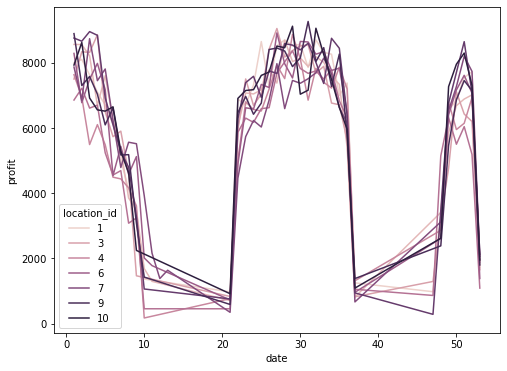

In [29]:
# rental Profit Variation
# We have cyclic pattern - Large profits during winter with snow tubing and during summer with river tubing
# This result indicates we should include the time dependence into account for modelling the profit for each location
df = df_profit
plt.figure(figsize=(8,6))
sns.lineplot(data=df.groupby([df['date'].dt.weekofyear, df['location_id']]).agg({'profit':'sum'}), x='date', y='profit', hue='location_id')

In [168]:
df_profit_norm_monthly

,location_id,profit,month,temperature,pressure,cloudy,precipitation,humidity,population,elevation,rent
0,1,0.857431,1.0,0.080927,0.500632,0.447368,0.245614,0.035088,0.013915,0.592476,snow
1,2,0.895273,1.0,0.083050,0.496421,0.538462,0.316239,0.189495,0.049049,0.275862,snow
2,3,0.911431,1.0,0.097466,0.372743,0.508621,0.336207,0.227675,0.148920,1.000000,snow
3,4,0.733485,1.0,0.000000,0.464255,0.504425,0.238938,0.147493,0.003802,0.545455,snow
4,5,0.742879,1.0,0.027736,0.493030,0.429825,0.201754,0.054131,0.000000,0.626959,snow
...,...,...,...,...,...,...,...,...,...,...,...
95,6,0.793602,12.0,0.121555,0.438576,0.616279,0.569767,0.210892,0.178568,0.780564,snow
96,7,0.870026,12.0,0.155942,0.512035,0.689655,0.563218,0.309264,0.001730,0.000000,snow
97,8,0.855959,12.0,0.201744,0.392855,0.626506,0.554217,0.249820,0.095720,0.664577,snow
98,9,0.789634,12.0,0.157657,0.478483,0.595238,0.523810,0.231990,0.002314,0.514107,snow


Text(0.5, 1.08, 'Monthly distribution')

<Figure size 576x432 with 0 Axes>

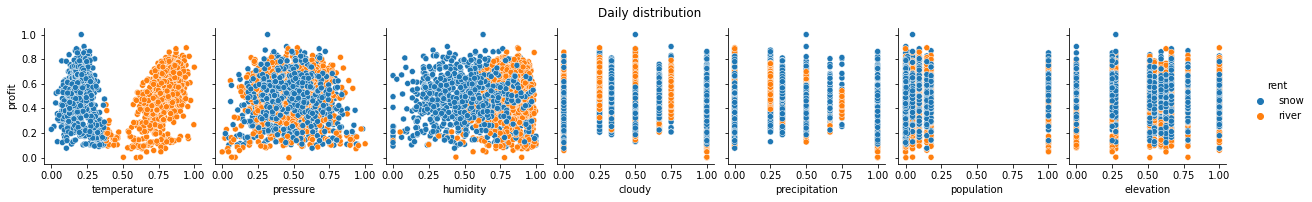

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

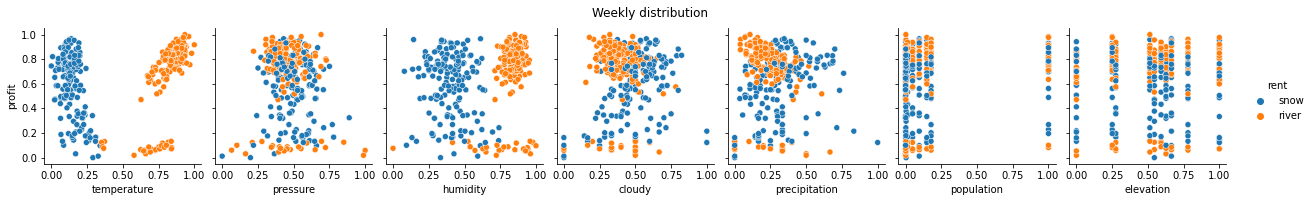

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

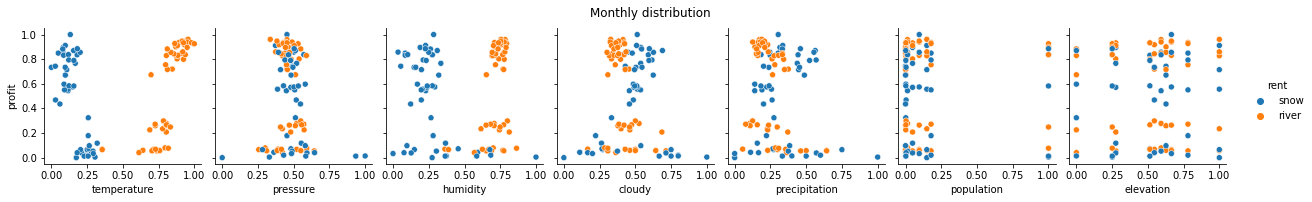

In [181]:
# Here I plotted the distributions of profit as a function of temperature for three different time windows
# Dt = {daily, weekly, monthly}
# Visually, the weekly time frame seems to capture the correlation with less noise
df = df_profit
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_daily, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent')
s.fig.suptitle('Daily distribution', y=1.08)

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_weekly, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent')
s.fig.suptitle('Weekly distribution', y=1.08)

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_monthly, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent')
s.fig.suptitle('Monthly distribution', y=1.08)

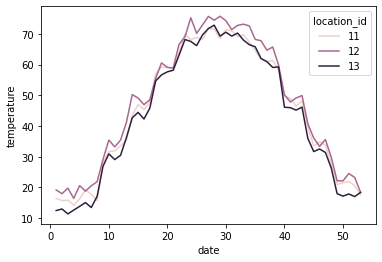

In [157]:
df = df_weather[df_weather['location_id'].isin([11,12,13])]
sns.lineplot(data=df.groupby([df['date'].dt.weekofyear, df['location_id']]).agg({'temperature':'mean'}), x='date', y='temperature', hue='location_id')
#sns.lineplot(data=df.groupby([df['date'].dt.month, df['location_id']]).agg({'temperature':'mean'}), x='date', y='temperature', hue='location_id', linestyle='--')

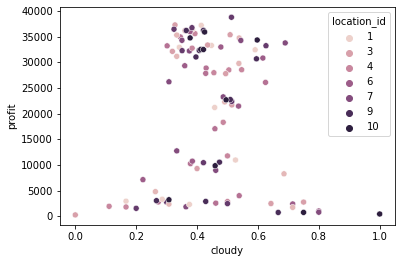

In [88]:
df = df_profit#[df_profit['location_id'].isin([1,2])]
sns.scatterplot(data=df.groupby([df['date'].dt.month, df['location_id']]).agg({'profit':'sum', 'cloudy':'mean'}), x='cloudy', y='profit', hue='location_id')

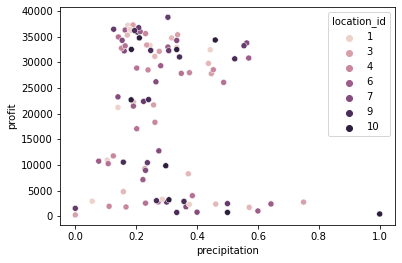

In [6]:
df = df_profit
sns.scatterplot(data=df.groupby([df['date'].dt.month, df['location_id']]).agg({'profit':'sum', 'precipitation':'mean'}), x='precipitation', y='profit', hue='location_id')

In [142]:
df_profit['date'].dt.year

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
7636    2022
7637    2022
7639    2022
7640    2022
7641    2022
Name: date, Length: 7252, dtype: int64

In [136]:
df_profit.groupby([df_profit['date'].dt.month,df_profit['location_id']]).agg({'profit':'count'})

profit
date location_id        
1    1               114
     2               117
     3               116
     4               113
     5               114
...                  ...
12   6                86
     7                87
     8                83
     9                84
     10               87

[100 rows x 1 columns]

In [154]:
df_profit[(df_profit['date'].dt.month == 3) & (df_profit['location_id'] == 1)]

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,season,day_of_year,population,elevation
58,1,2019-03-01,161.43,24.44,1016.995305,0.00,0.0,0.0,w,60.0,18428,375
252,1,2020-03-01,195.88,33.08,1008.298122,0.75,0.0,0.0,s,61.0,18428,375
253,1,2020-03-02,112.15,36.32,990.457746,0.52,0.0,0.0,s,62.0,18428,375
254,1,2020-03-03,95.45,36.14,963.251174,0.41,0.0,0.0,s,63.0,18428,375
255,1,2020-03-04,118.07,35.60,1021.009390,0.08,0.0,0.0,s,64.0,18428,375
256,1,2020-03-05,87.87,26.42,1028.814554,1.00,1.0,1.0,w,65.0,18428,375
257,1,2020-03-06,190.26,28.76,1018.110329,0.90,1.0,0.0,w,66.0,18428,375
653,1,2022-03-01,182.18,33.98,971.725352,0.64,0.0,0.0,s,60.0,18428,375
654,1,2022-03-02,146.06,28.76,992.464789,0.90,0.0,0.0,w,61.0,18428,375
655,1,2022-03-03,142.68,24.26,1018.556338,0.07,0.0,0.0,w,62.0,18428,375


In [180]:
df_profit_norm_daily

profit  temperature  pressure  humidity  cloudy  \
date location_id                                                      
2    1            0.625411     0.145228  0.560000  0.520000    0.00   
     2            0.682216     0.138485  0.367059  0.435000    0.50   
     3            0.645865     0.209025  0.405294  0.500000    0.25   
     4            0.646499     0.089212  0.331176  0.585000    0.50   
     5            0.680786     0.170816  0.443922  0.426667    0.00   
...                    ...          ...       ...       ...     ...   
366  6            0.450920     0.180498  0.795294  0.360000    1.00   
     7            0.667753     0.248963  0.336471  0.650000    0.00   
     8            0.645695     0.278008  0.898824  0.000000    1.00   
     9            0.627431     0.207469  0.861176  0.860000    1.00   
     10           0.438672     0.124481  0.680000  0.730000    1.00   

                  precipitation  day_of_year  population  elevation season  
date location_id                                                            
2    1                     0.00          0.0    0.013915   0.592476      w  
     2                     0.25          0.0    0.049049   0.275862      w  
     3                     0.25          0.0    0.148920   1.000000      w  
     4                     0.50          0.0    0.003802   0.545455      w  
     5                     0.00          0.0    0.000000   0.626959      w  
...                         ...          ...         ...        ...    ...  
366  6                     1.00          1.0    0.178568   0.780564      w  
     7                     0.00          1.0    0.001730   0.000000      w  
     8                     0.00          1.0    0.095720   0.664577      w  
     9                     0.00          1.0    0.002314   0.514107      w  
     10                    0.00          1.0    1.000000   0.250784      w  

[2152 rows x 10 columns]

Text(0.5, 1.0, 'Profit correlation - Weekly window')

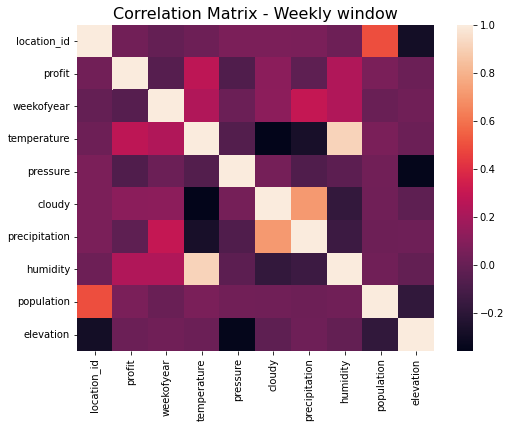

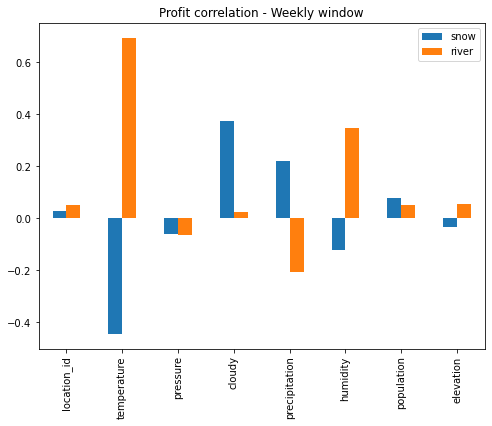

In [171]:
# Correlation Matrix for normalized Dt=daily profit dataframe
fig = plt.figure(figsize=(8, 6))
h = sns.heatmap(df_profit_norm_weekly.corr())
#plt.xticks(range(df_profit_norm.select_dtypes(['number']).shape[1]), df_profit_norm.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df_profit_norm.select_dtypes(['number']).shape[1]), df_profit_norm.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
h.set_title('Correlation Matrix - Weekly window', fontsize=16)

# Profit correlation to the other variables
df_cor = pd.DataFrame()
for rent in ['snow', 'river']:
    df_cor[rent] = df_profit_norm_weekly[df_profit_norm_weekly['rent']==rent].drop('weekofyear',axis=1).corr()['profit'].drop('profit')
df_cor.plot.bar(figsize=(8, 6))
#df_nor[df_nor['rent']=='river'].corr()['profit'].drop('profit').plot.bar()
plt.title('Profit correlation - Weekly window')

Model river 0.46816775129803934
Model snow 0.2414952579484846


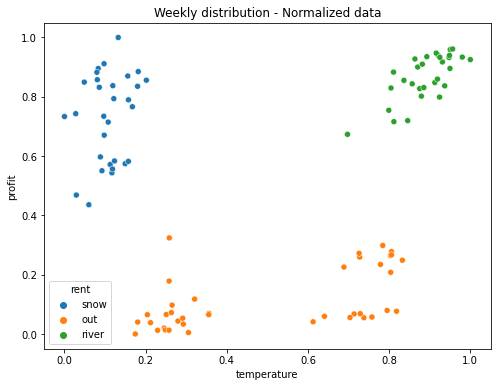

In [183]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Remove outliners
df = df_profit_norm_monthly.copy()
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'out' if (x['profit'] < 0.4) & (x['rent'] == 'snow') else x['rent'], axis=1)
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'out' if ((x['profit'] < 0.4) or (x['temperature'] < 0.6)) & (x['rent'] == 'river') else x['rent'], axis=1)

# Plot dataframe distribution
plt.figure(figsize=(8,6))
s = sns.scatterplot(data=df, x='temperature', y='profit', hue='rent')
s.set_title('Weekly distribution - Normalized data')

# Train-Test data
# Season dependent model
# River tubing and Snow tubing
model = []
for rent in ['river', 'snow']:
    x = df.loc[df['rent']==rent,['temperature', 'pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation']].to_numpy()
    #x = df.loc[df['rent']==rent,['temperature']].to_numpy()
    y = df.loc[df['rent']==rent,'profit'].to_numpy()
    y = y.reshape(-1, 1)

    # Linear model training
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

    # Model Fit + Prediction
    model.append(LinearRegression())
    model[-1].fit(xtrain, ytrain)
    #model[-1].fit(x, y)
    ypred = model[-1].predict(xtest)
    ypred = ypred.reshape(1,-1)[0]
    print('Model',rent,model[-1].score(xtest,ytest))

    # Plotting linear regression
    line_x = np.linspace(x[:,0].min(), x[:,0].max(), 100)
    line_y = model[-1].intercept_[0] + model[-1].coef_[0][0]*line_x
    #sns.lineplot(x=line_x, y=line_y, linestyle='-', color='red')
    #sns.lineplot(x=xtest[:,0], y=ypred, linestyle='-', color='red')
#plt.text(line_x[-1]*1.1, line_y[-1]*1.1, f"R^2 = {rent}", horizontalalignment='left', size='medium', color='black')
#s.legend(labels=['Summer', 'Winter'])

# Predict profit for new locations
new_loc = [11,12,13]
df_weather_new_loc = df_weather[df_weather['location_id'].isin(new_loc)]
df_weather_new_loc_weekly = df_weather_new_loc.groupby([df_weather_new_loc['location_id'], df_weather_new_loc['date'].dt.weekofyear], as_index=False).agg('mean')
df_weather_new_loc_weekly['rent'] = df_weather_new_loc_weekly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')

In [162]:
df_weather_new_loc_weekly

,location_id,temperature,pressure,humidity,cloudy,precipitation,rent
0,11,16.420000,1006.951834,0.534074,0.592593,0.296296,snow
1,11,15.686667,996.264128,0.468519,0.481481,0.296296,snow
2,11,15.862308,1001.891026,0.637692,0.423077,0.153846,snow
3,11,14.240000,1008.281603,0.565556,0.518519,0.370370,snow
4,11,16.208462,991.641387,0.601538,0.615385,0.269231,snow
...,...,...,...,...,...,...,...
154,13,17.960000,998.496535,0.487143,0.571429,0.380952,snow
155,13,17.171429,1009.445003,0.444762,0.666667,0.476190,snow
156,13,17.855789,990.223005,0.608947,0.684211,0.473684,snow
157,13,17.022105,997.535211,0.586316,0.631579,0.578947,snow


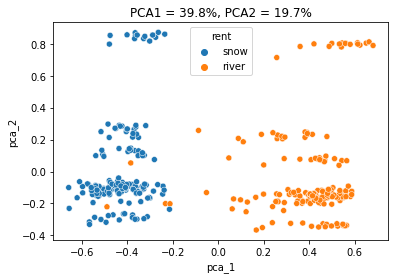

In [149]:
# PCA - Principal Component Analysis
from sklearn.decomposition import PCA

# Number of components
n_components = 5

# PCA Fit
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(df_profit_norm_weekly.drop(['location_id','rent'],axis=1))
df_pca = pd.DataFrame(data=principalComponents, columns=[f'pca_{i}' for i in range(1,n_components+1)])
df_pca = pd.concat([df_pca, df_profit_norm_weekly['rent']], axis=1)

# Plot along the 2 largest PCA components
# The 2 main PCA componentes explain 96% of the data variance
s = sns.scatterplot(data=df_pca, x='pca_1', y='pca_2', hue='rent').\
    set(title=f'PCA1 = {pca.explained_variance_ratio_[0]*100:.1f}%, PCA2 = {pca.explained_variance_ratio_[1]*100:.1f}%')

# PCA componentes in terms of the original variables
print('')

In [144]:
df_profit_norm_weekly

,location_id,profit,temperature,pressure,cloudy,precipitation,humidity,population,elevation,rent
0,1,0.860154,0.121222,0.587452,0.500000,0.291667,0.225795,0.013915,0.592476,snow
1,2,0.922534,0.097088,0.408973,0.640000,0.400000,0.491329,0.049049,0.275862,snow
2,3,0.805790,0.092232,0.362870,0.608696,0.347826,0.621387,0.148920,1.000000,snow
3,4,0.820376,0.008540,0.437110,0.520000,0.240000,0.223699,0.003802,0.545455,snow
4,5,0.735015,0.048635,0.400231,0.434783,0.217391,0.265770,0.000000,0.626959,snow
...,...,...,...,...,...,...,...,...,...,...
332,6,0.133177,0.077856,0.646388,0.600000,0.400000,0.500000,0.178568,0.780564,snow
333,7,0.208136,0.170930,0.507605,0.666667,0.333333,0.696050,0.001730,0.000000,snow
334,8,0.215145,0.197926,0.290875,1.000000,0.833333,0.503372,0.095720,0.664577,snow
335,9,0.178772,0.145648,0.558302,0.333333,0.166667,0.279383,0.002314,0.514107,snow


In [146]:
pca.components_

array([[ 0.24012463,  0.80165197, -0.01932492, -0.12263219, -0.10676083,
         0.51838965,  0.06437142,  0.00357742],
       [ 0.0549977 , -0.04340877,  0.11118522,  0.05175245,  0.02035968,
        -0.02586439,  0.74560781, -0.65041216],
       [-0.66812848,  0.12190898,  0.13100608, -0.2010238 , -0.1462652 ,
         0.10232973, -0.4065517 , -0.53293547],
       [-0.64903462,  0.0957074 , -0.08618567, -0.16988748, -0.07192449,
         0.02615237,  0.52170129,  0.50524757],
       [-0.24815863,  0.06786707, -0.01202744,  0.60926001,  0.68657959,
         0.29954061, -0.03537669, -0.01006559]])

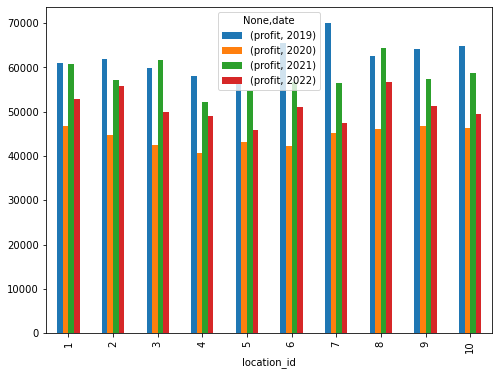

In [131]:
# Profit of each location for each year
df_yea = df_transaction.groupby([df_transaction['location_id'],df_transaction['date'].dt.year])[['profit']].agg('sum')
df_yea.unstack('date').plot.bar(figsize=(8,6))

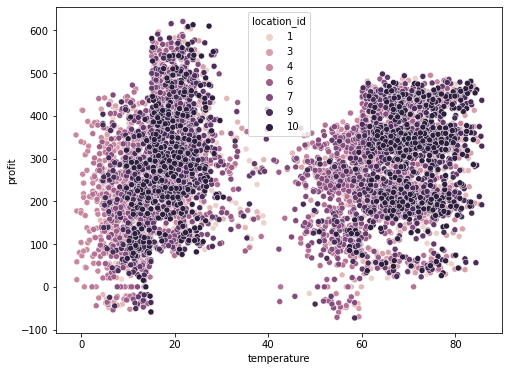

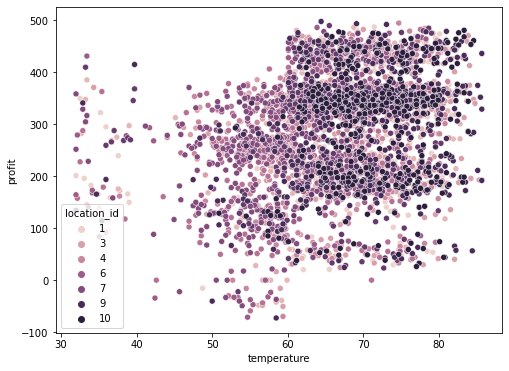

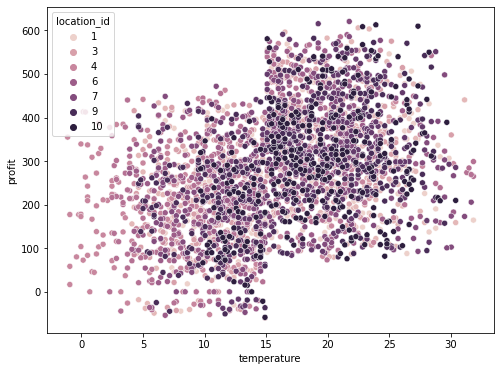

In [180]:
# Total profit for each day for all locations
df = df_profit
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='temperature', y='profit', hue='location_id')

plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['rent']=='river'], x='temperature', y='profit', hue='location_id')
plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['rent']=='snow'], x='temperature', y='profit', hue='location_id')

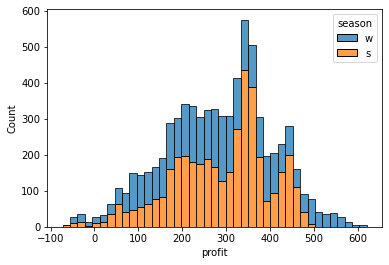

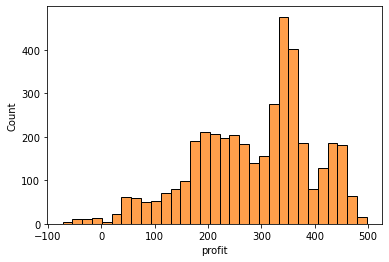

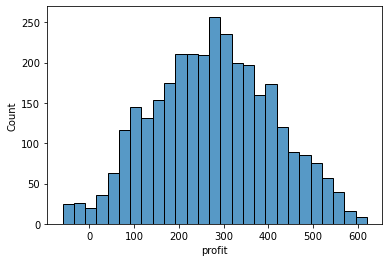

In [35]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='profit', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='profit', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='profit')

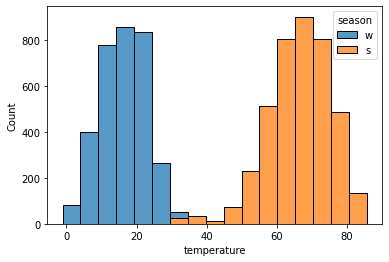

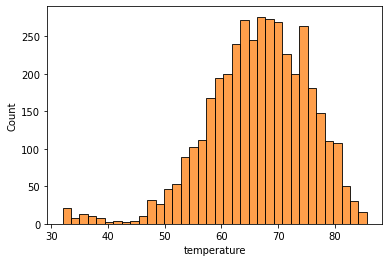

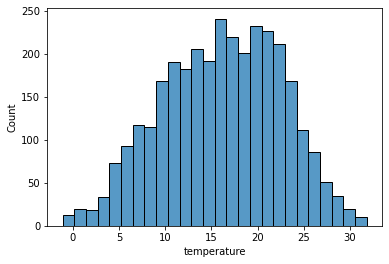

In [34]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='temperature', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='temperature', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='temperature')

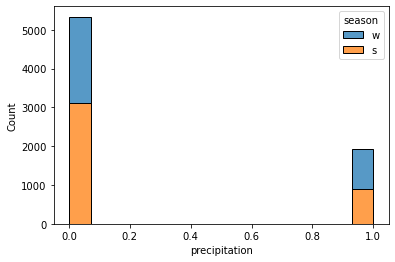

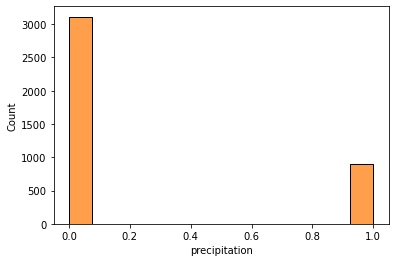

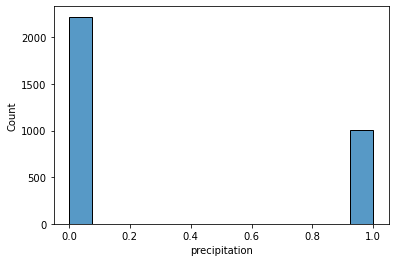

In [36]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='precipitation', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='precipitation', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='precipitation')

In [290]:
df_profit_norm_daily

profit  temperature  pressure  humidity  cloudy  \
date location_id                                                      
2    1            0.672462     0.131094  0.555283  0.520000    0.00   
     2            0.738479     0.124052  0.353808  0.435000    0.50   
     3            0.696233     0.197725  0.393735  0.500000    0.25   
     4            0.696970     0.072589  0.316339  0.585000    0.50   
     5            0.736817     0.157819  0.434070  0.426667    0.00   
...                    ...          ...       ...       ...     ...   
366  6            0.469674     0.167931  0.800983  0.360000    1.00   
     7            0.721671     0.239437  0.321867  0.650000    0.00   
     8            0.696036     0.269772  0.909091  0.000000    1.00   
     9            0.674809     0.196100  0.869779  0.860000    1.00   
     10           0.455439     0.109426  0.680590  0.730000    1.00   

                  precipitation  day_of_year  population  elevation season  
date location_id                                                            
2    1                     0.00          0.0    0.013915   0.592476      w  
     2                     0.25          0.0    0.049049   0.275862      w  
     3                     0.25          0.0    0.148920   1.000000      w  
     4                     0.50          0.0    0.003802   0.545455      w  
     5                     0.00          0.0    0.000000   0.626959      w  
...                         ...          ...         ...        ...    ...  
366  6                     1.00          1.0    0.178568   0.780564      w  
     7                     0.00          1.0    0.001730   0.000000      w  
     8                     0.00          1.0    0.095720   0.664577      w  
     9                     0.00          1.0    0.002314   0.514107      w  
     10                    0.00          1.0    1.000000   0.250784      w  

[2152 rows x 10 columns]

In [288]:
# Total profit for each day for all locations
col = df_profit_norm_daily['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit_norm_daily.plot.scatter(x='pressure', y='profit', c=col, figsize=(8,6))

col_s = df_profit_norm_daily[df_profit_norm_daily['rent']=='river']['location_id'].map({i:f'C{i}' for i in range(11)})
col_w = df_profit_norm_daily[df_profit_norm_daily['rent']=='snow']['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit_norm_daily[df_profit_norm_daily['rent']=='river'].plot.scatter(x='pressure', y='profit', c=col_s, figsize=(8,6), title='summer')
df_profit_norm_daily[df_profit_norm_daily['rent']=='snow'].plot.scatter(x='pressure', y='profit', c=col_w, figsize=(8,6), title='winter')

KeyError: 'location_id'

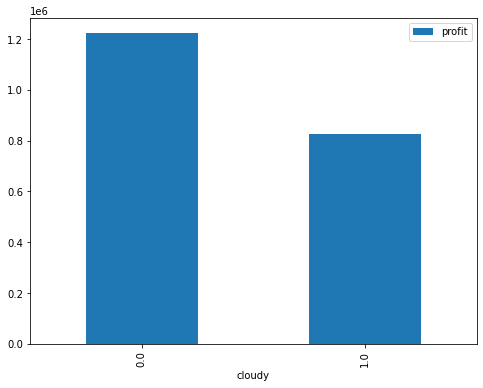

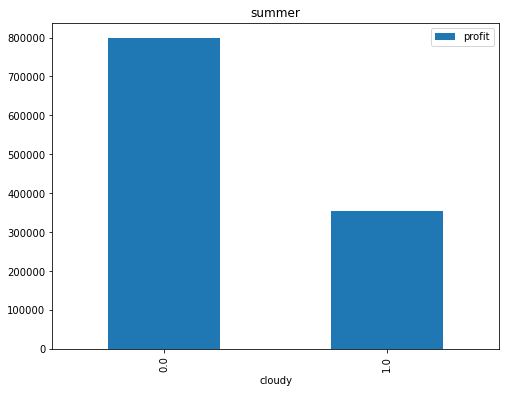

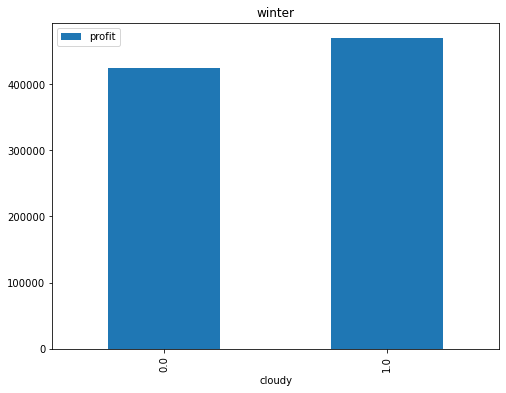

In [46]:
# Total profit for each day for all locations
col = df_profit['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit.groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6))

col_s = df_profit[df_profit['rent']=='river']['location_id'].map({i:f'C{i}' for i in range(11)})
col_w = df_profit[df_profit['rent']=='snow']['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit[df_profit['rent']=='river'].groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6), title='summer')
df_profit[df_profit['rent']=='snow'].groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6), title='winter')

In [65]:
df_profit.describe()

,location_id,profit,temperature,pressure,humidity,cloudy,precipitation,population,elevation
count,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000
mean,5.493657,282.255153,43.993356,1001.474523,0.691995,0.438776,0.264341,73363.085080,352.880033
std,2.863817,120.936549,26.236902,25.112211,0.305839,0.496272,0.441012,118531.950909,87.194837
min,1.000000,-72.750000,-1.120000,955.000000,0.000000,0.000000,0.000000,12686.000000,186.000000
25%,3.000000,198.190000,17.420000,979.920775,0.550000,0.000000,0.000000,13641.000000,274.000000
50%,6.000000,292.905000,55.220000,1001.384977,0.800000,0.000000,0.000000,18428.000000,375.000000
75%,8.000000,362.292500,68.000000,1023.016432,0.930000,1.000000,1.000000,74138.000000,398.000000
max,10.000000,620.410000,85.640000,1049.776995,1.000000,1.000000,1.000000,425336.000000,505.000000
